<img src="../images/cads-logo.png" style="height: 100px;" align=left> 
<img src="../images/sklearn-logo.png" style="height: 100px;" align=right>

# Unsupervised Machine Learning

# Clustering

- [Clustering](#Clustering)
- [k-Means Clustering](#k-Means-Clustering)
    - [Introducing k-Means](#Introducing-k-Means)
    - [Elbow Method: optimal number of clusters](#Elbow-Method:-optimal-number-of-clusters)
    - [k-Means Algorithm: Expectation–Maximization](#k-Means-Algorithm:-Expectation–Maximization)
    - [Caveats of expectation–maximization](#Caveats-of-expectation–maximization)
        - [The globally optimal result may not be achieved:](#The-globally-optimal-result-may-not-be-achieved:)
        - [The number of clusters must be selected beforehand:](#The-number-of-clusters-must-be-selected-beforehand:)
        - [k-means is limited to linear cluster boundaries:](#k-means-is-limited-to-linear-cluster-boundaries:)
        - [k-means can be slow for large numbers of samples](#k-means-can-be-slow-for-large-numbers-of-samples)
- [Evaluation of Clustering:](#Evaluation-of-Clustering:)
    - [Clustering Evaluation Metrics (True label known)](#Clustering-Evaluation-Metrics-(True-label-known))
        - [Adjusted Rand Index:](#Adjusted-Rand-Index:)
        - [v_measure:](#v_measure:)
    - [Clustering Evaluation Metrics (True label unknown)](#Clustering-Evaluation-Metrics-(True-label-unknown))
        - [Davies-Bouldin Index:](#Davies-Bouldin-Index:)
- [Density-Based Spatial Clustering of Applications with Noise (DBSCAN):](#Density-Based-Spatial-Clustering-of-Applications-with-Noise-(DBSCAN):)
- [Agglomerative Clustering](#Agglomerative-Clustering)
    - [Dendrogram](#Dendrogram)
        - [Dendrogram Truncation](#Dendrogram-Truncation)
        - [Interpreting the dendrogram further](#Interpreting-the-dendrogram-further)
    - [Cophenetic Correlation Coefficient](#Cophenetic-Correlation-Coefficient)
- [Reference](#Reference)

# k-Means Clustering

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
import numpy as np

### Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple concept of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly how the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

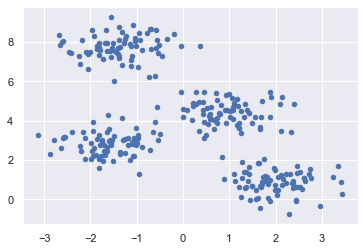

In [12]:
# from sklearn.datasets.samples_generator import make_blobs

from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=20);

In [3]:
X[:10]

array([[ 0.83685684,  2.13635938],
       [-1.4136581 ,  7.40962324],
       [ 1.15521298,  5.09961887],
       [-1.01861632,  7.81491465],
       [ 1.27135141,  1.89254207],
       [ 3.43761754,  0.26165417],
       [-1.80822253,  1.59701749],
       [ 1.41372442,  4.38117707],
       [-0.20493217,  8.43209665],
       [-0.71109961,  8.66043846]])

In [4]:
y_true[:10]

array([1, 3, 0, 3, 1, 1, 2, 0, 3, 3])

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [39]:
# output - cluster center

kmeans.cluster_centers_

array([[-1.37324398,  7.75368871],
       [ 0.94973532,  4.41906906],
       [ 1.98258281,  0.86771314],
       [-1.58438467,  2.83081263]])

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

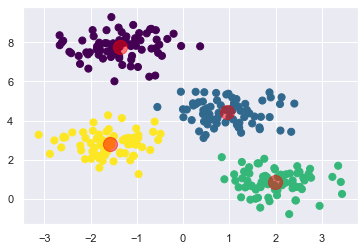

In [40]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

The good news is that the *k-means* algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k-means* involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
For an interactive version of this figure, refer to the code in [the Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Interactive-K-Means).

![(image)](../images/expectation-maximization.png)


The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

[[ 0.27239604  5.46996004]
 [-1.36999388  7.76953035]
 [ 0.08151552  4.56742235]
 [-0.6149071   3.94963585]]


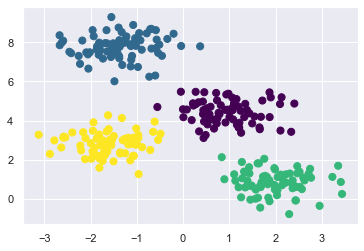

In [41]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    print(centers)
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

## Caveats of K-Means

There are a few issues to be aware of when using the expectation–maximization algorithm.

### 1. The globally optimal result may not be achieved:
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

In [44]:
def find_clusters_2(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    start = centers
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return start, centers, labels

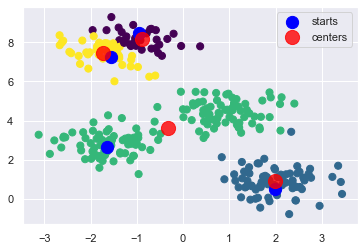

In [45]:
starts, centers, labels = find_clusters_2(X, 4, rseed=3)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter(starts[:, 0], starts[:, 1], c='blue', s=150, alpha=1, label='starts')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8, label='centers')
plt.legend()

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed `Scikit-Learn` does by default (set by the ``n_init`` parameter, which defaults to 10). 

### 2. The number of clusters must be selected beforehand:
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

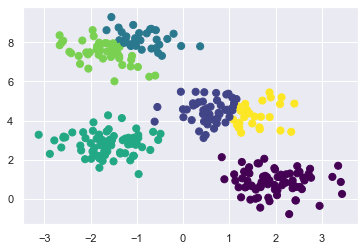

In [46]:
model = KMeans(6, random_state=0)
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


#### Elbow Method: optimal number of clusters

Elbow method is one technique that helps to find the optimal number of the clusters. It calculates inertia score for each clustering result (with different number of clusters) and chooses the optimal number of the cluster.

The inertia is the sum of squared distances of samples to their closest cluster center.
$$\sum_{i=1}^{k}{\sum_{x \in C_i}{(x-c_i)^2}}.$$ Where $x=(x_1,x_2, ..., x_n)$ is a datapoint in cluster $C_i$ with centriod $c_i=(c_{i1}, c_{i2}, ..., c_{in})$.

According to the above definition, the lower inertia value indicate denser clusters.

http://scikit-learn.org/stable/modules/clustering.html#k-means

The following code plots Inertia scores by number of the clusters. Based on this plot we can conclude the best number of the clusters is 4 as there is no significant decrease in Inertia score by increasing the number of the clusters to 5 and 6.

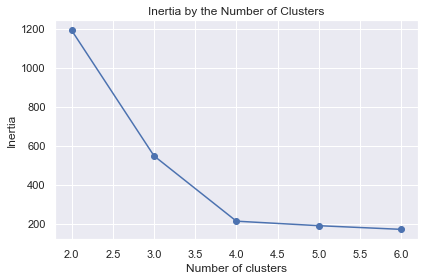

In [49]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

range_n_clusters = [2, 3, 4, 5, 6]

inertia = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia by the Number of Clusters')
plt.tight_layout()
plt.show()

In [50]:
# 4 best coz increasing the cluster not decrease much

In [51]:
print('Inertia: %.2f' % kmeans.inertia_)

Inertia: 170.04


Another approach that is rather intuitive, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html): http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

#### Silhouette Analysis: optimal number of clusters

Silhouette analysis can be used to study the separation distance between the resulting clusters. We will learn more detail about Silhouette coefficient in "*Clustering Evaluation Metrics (True label unknown)*" later in this notebook.

This coefficient has a range of [-1, 1]. Silhouette coefficients near +1 indicate highly-dense well-separated clusters. A value of 0 indicates overlapping clusters and value of -1 means incorrect clustering.  

The following code calculates:

- For each n_clusters in range_n_clusters:

    1. Fit k-means on X and predict the cluster labels:
    
       `clusterer = KMeans(n_clusters=n_clusters, random_state=10)`
       
       `cluster_labels = clusterer.fit_predict(X)`      
  
    2. Average Silhouette values for each sample (datapoint) in the clusters:
    
       `silhouette_avg = silhouette_score(X, cluster_labels)`
       
    3. Computes Silhouette values for each sample (datapoint) in the clusters:
    
       `sample_silhouette_values = silhouette_samples(X, cluster_labels)` 
    
    4. For each cluster `i`, sorts Silhouette values for each sample (datapoint) in the cluster:
    
       `ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]`
       
       `ith_cluster_silhouette_values.sort()`
            
    5. Plot sorted Silhouette values in each cluster as a horizontal bars: 
    
       `ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,/
          facecolor=color, edgecolor=color, alpha=0.7)`
          
    6. The length of the bar represents the maximum Silhouette value in the cluster and    the width of the bar indicates the size of the cluster:       
       `size_cluster_i = ith_cluster_silhouette_values.shape[0]`      
       `y_upper = y_lower + size_cluster_i`  
       
According to the results of the average Silhouette values for each clustering and the related plots we can conclude the best number of the clusters is 4 with the highest Silhouette value 0.68.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.54
For n_clusters = 3 The average silhouette_score is : 0.59
For n_clusters = 4 The average silhouette_score is : 0.68
For n_clusters = 5 The average silhouette_score is : 0.59
For n_clusters = 6 The average silhouette_score is : 0.5


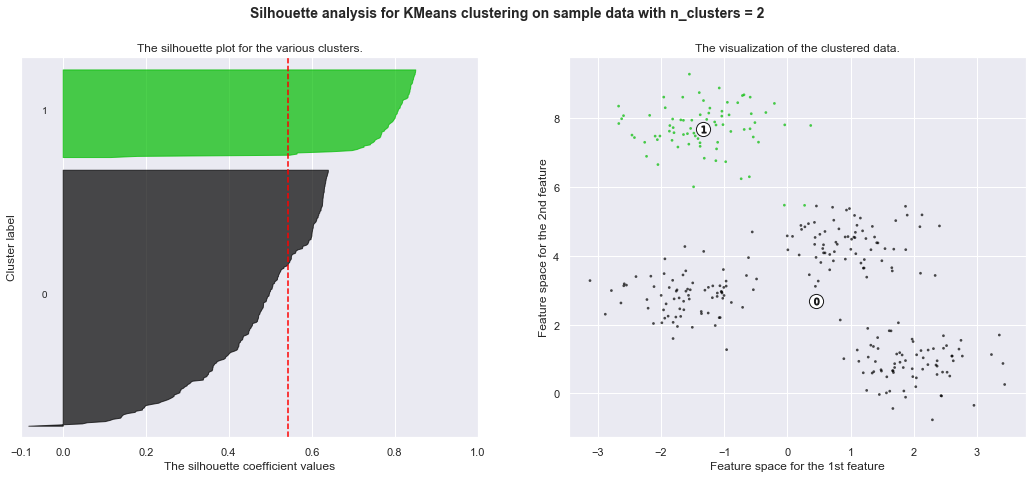

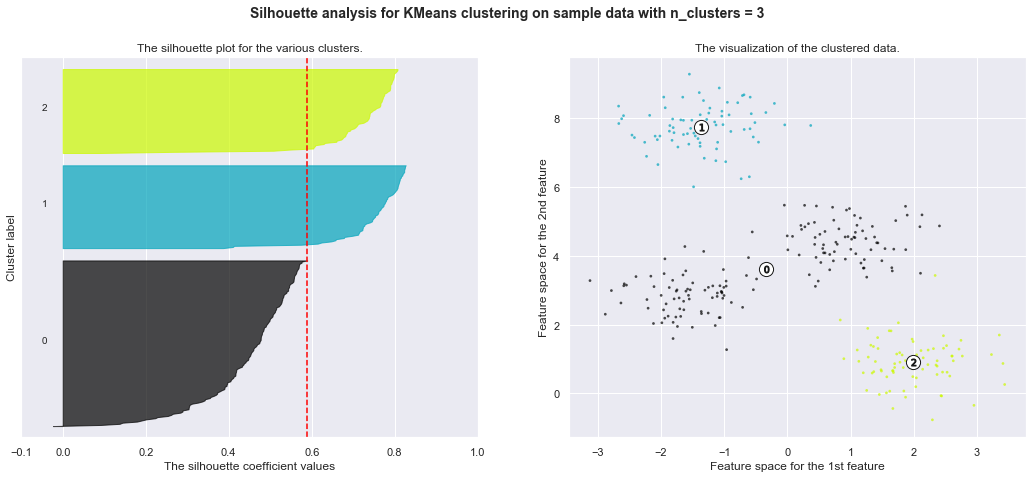

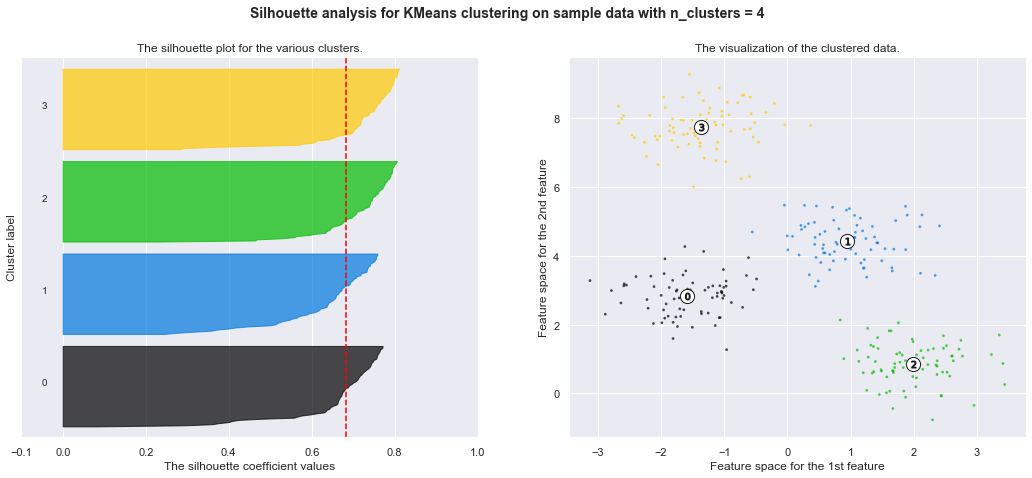

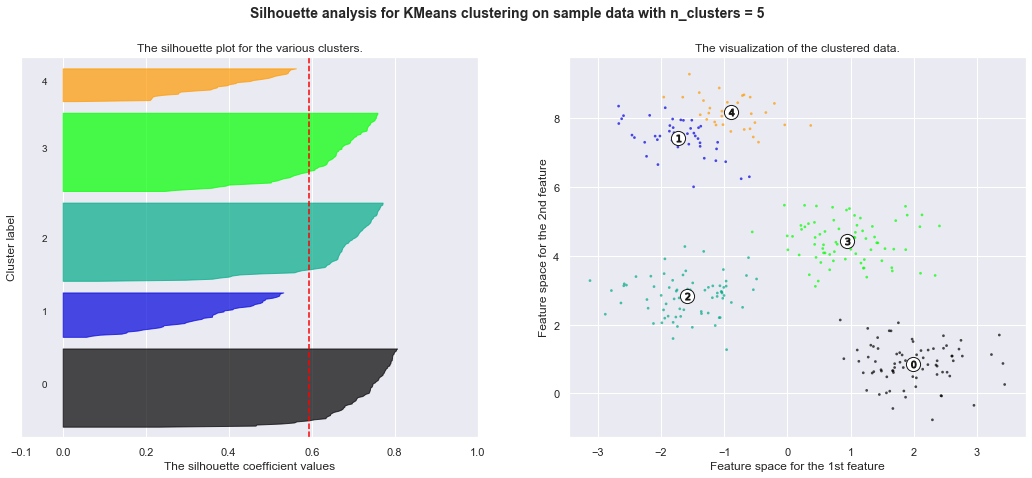

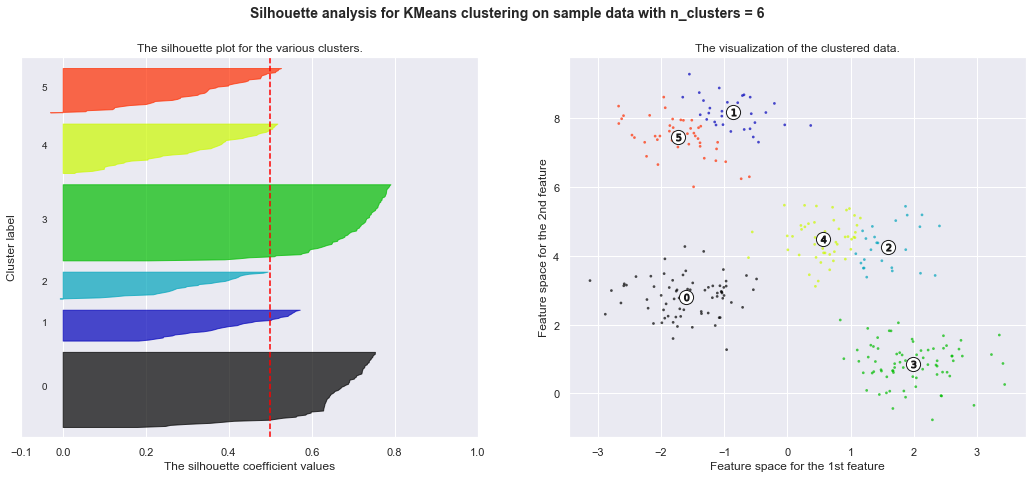

In [52]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg, 2))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### 3. k-means is limited to linear cluster boundaries:

The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k-means* clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k-means* approach:

In [53]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

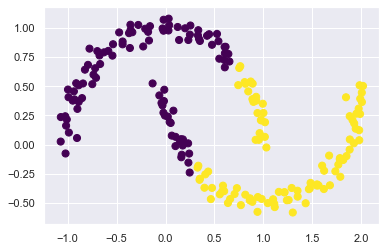

In [54]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in `Support Vector Machines`, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k-means* is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.

It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k-means* algorithm:

D:\Users\Faiz\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


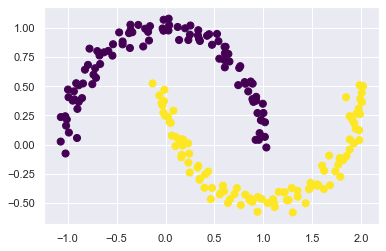

In [55]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

### 4. k-means can be slow for large number of samples
Because each iteration of *k-means* must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``K-means``.

Also in `Scikit-Learn` the hyperparameter ``init`` in `KMeans` has been set `''k-means++''` that selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 

**Examples:**

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at a couple examples.

**Example 1: k-means on digits**

To start, let's take a look at applying *k*-means on the same simple digits data. Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [56]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [59]:
digit_km = KMeans(n_clusters=10, random_state=0)
clusters = digit_km.fit_predict(digits.data)
digit_km.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

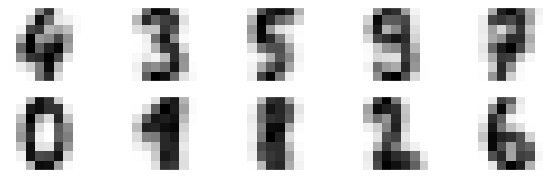

In [60]:
fig, ax = plt.subplots(2, 5, figsize=(10, 3))
centers = digit_km.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps some exceptions.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [61]:
digits.target[clusters==0]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [62]:
from scipy.stats import mode #most common value

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    most_occurring = mode(digits.target[mask])[0]
    labels[mask] = most_occurring
    print("cluster:",i,"label:",most_occurring)

cluster: 0 label: [4]
cluster: 1 label: [3]
cluster: 2 label: [5]
cluster: 3 label: [9]
cluster: 4 label: [7]
cluster: 5 label: [0]
cluster: 6 label: [1]
cluster: 7 label: [8]
cluster: 8 label: [2]
cluster: 9 label: [6]


Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

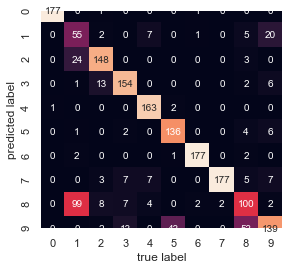

In [64]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Evaluation of Clustering:

Evaluating the performance of a clustering algorithm is not as strightforward as that for classification algorithm.

### Clustering Evaluation Metrics (True label known)

Knowing the true labels of our datapoints helps us to define the following metrics:

#### Adjusted Rand Index:

**Measures the similarity between `y_true` and `y_pred`.**

To calculate similarity between two cluster assignments in `y_true` and `y_pred`, this metric calculates:
   - a: The number of pairs of elements that are in the same set in `y_true` and in the same set in `y_pred`
   - b: The number of pairs of elements that are in different sets in `y_true` and in different sets in `y_pred`

$$Rand_{Index}=RI=\frac{a+b}{{n\choose 2}}$$, where n=number of datapoints=length of `y_true`
Perfect labeling has RI=1.0 and bad labeling has RI=0.0. 
Adjusted Rand Index, adjusts the Rand Index such that random assignment of the labels results in Adjusted_Rand_Index=0. Adjusted Rand Index is 1.0 for perfecr labeling and zero or negative for bad labeling.

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(digits.target, clusters) 

#### v_measure:

To evaluate the goodness of the clustering v_measure uses the following metrics:

    - Homogeneity: each cluster contains only members of a single class.
    - Completeness: all members of a given class are assigned to the same cluster.

Then v_measure is the harmonic mean of them. $$v_{measure}=2\times \frac{h \times c}{h + c}$$

In [128]:
h=metrics.homogeneity_score(digits.target, clusters) 
print('homogeneity_score:', h)
c=metrics.completeness_score(digits.target, clusters) 
print('completeness_score:', c)
v=metrics.v_measure_score(digits.target, clusters) 
print('v_measure:',v)
v_manual=2*h*c/(h+c)
v==v_manual

homogeneity_score: 0.7423769268336259
completeness_score: 0.7514312243853245
v_measure: 0.746876635571714


True

### Clustering Evaluation Metrics (True label unknown)

In the above example, we could use the confusion metrix or accuracy because we knew the true digit in each image however, clustering is an unsupervised algorithm that clusters (labels) datapoints only based on their features without knowing the real labeles of them. To evaluate the *goodness* of the resulting clusters, we need clustering evaluation metrics.

To evaluate the goodness of a clustering model or comparing the performance of variuos clustering algorithms we need to evaluate the resulting clusters. Basically, a good clustering algorithm generates clusters with high intracluster homogeneity and good inter-cluster separation.

#### Silhouette Coefficient:
**This measure evaluates how similar an object is to its own cluster (*cohesion*) compared to other clusters (*separation*).**

    - a: The mean distance between a sample and all other points in its cluster (*cohesion*).
    - b: The mean distance between a sample and all other points in the next nearest cluster (*separation*).

Silhouette Coefficient=$\frac{b-a}{max(a,b)}$

    - This score is bounded between -1 and +1.
    - For highly-dense well-separated clusters a is close to zero and b is positive, therefore s is close to +1.
    - For incorrect clustering s is close to -1.
    - Scores around zero indicate overlapping clusters.
    
**Attention**: We mainly use Silhouette Coefficien to find the best number of the clusters similar to the elbow method.

In [65]:
from sklearn import metrics
s=metrics.silhouette_score(digits.data, clusters, metric='euclidean')
print('silhouette_score:', s)

silhouette_score: 0.18251916424600556


#### Davies-Bouldin Index:
**This measure evaluates the average similarity between each cluster $C_i$ for $i=1, 2, \dots, k$ and its most similar one $C_j$.**
 - $s_i$: the average distance between each point of cluster i and the centroid of that cluster – also know as cluster diameter.
 - $d_{ij}$:the distance between cluster centroids $C_i$ and $C_j$.
 $$R_{ij}=\frac{s_i+s_j}{d_ij}$$
 
 Davies-Bouldin index= DB=$\frac{1}{k} \sum_{i=1}^{k} {max(R_{ij})}$
 
 **Attention:** For good clustering, this value is close to zero. 

In [66]:
from sklearn.metrics import davies_bouldin_score
db=davies_bouldin_score(digits.data, clusters)  
print('davies_bouldin_score: ', db)

davies_bouldin_score:  1.9217506118603165


**Exercise: K-means on the Iris dataset**

- Load the iris data set using sklearn datasets.
- Set X to contain the feature matrix.
- Set y to contain the target vector.
- Fit a Kmeans Clustering model with 3 clusters
- Get resulting groups.
- Just like in the digits example, for each group, find the most occuring flower type for each group.
- Having the labels for each group, see the confusion matrix and the accuracy score
- Use the above clustering evaluation metrics (with/without true y) to evaluate the performance of your clustering.
- Do we really see three flower groups here or should there be more/less? Plot using the elbow method. Plot using the Silhouette Coefficient.
- Does scaling the data improve the performance of your clustering?

exercise: https://padlet.com/kuanhoong1/zczg84qyzr30hbec

In [70]:
# imports

import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [101]:
# get Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [102]:
## MC Feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_scaled = StandardScaler().fit_transform(X)

In [109]:
# Fit a Kmeans Clustering model with 3 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(X_scaled)
cluster = kmeans.predict(X_scaled)

In [110]:
# Get resulting groups.
kmeans.cluster_centers_

array([[-0.05021989, -0.88337647,  0.34773781,  0.2815273 ],
       [-1.01457897,  0.85326268, -1.30498732, -1.25489349],
       [ 1.13597027,  0.08842168,  0.99615451,  1.01752612]])

In [112]:
# MC
# Get resulting groups.
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [113]:
# Just like in the digits example, for each group, find the most occuring flower type for each group.
# my answer
print("0",y[cluster ==0])
print("1",y[cluster ==1])
print("2",y[cluster ==2])

0 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
1 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
2 [1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2]


In [121]:
# MC
from scipy.stats import mode #most common value

labels = np.zeros_like(cluster)
for i in range(3):
    mask = (cluster == i)
    most_occurring = mode(y[mask])[0]
    labels[mask] = most_occurring
    print("cluster:",i,"label:",most_occurring)


cluster: 0 label: [1]
cluster: 1 label: [0]
cluster: 2 label: [2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [116]:
# Having the labels for each group, see the confusion matrix and the accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y, labels)

0.8333333333333334

array([[50,  0,  0],
       [ 0, 39, 11],
       [ 0, 14, 36]], dtype=int64)

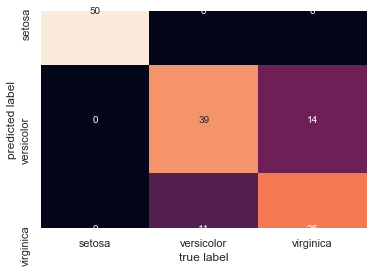

In [135]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

confusion_matrix(y, labels)

In [ ]:
# Use the above clustering evaluation metrics (with/without true y) to evaluate the performance of your clustering.

In [127]:
from sklearn import metrics
metrics.adjusted_rand_score(y, cluster) 

0.6201351808870379

In [129]:
h=metrics.homogeneity_score(y, cluster) 
print('homogeneity_score:', h)
c=metrics.completeness_score(y, cluster) 
print('completeness_score:', c)
v=metrics.v_measure_score(y, cluster) 
print('v_measure:',v)
v_manual=2*h*c/(h+c)
v==v_manual

homogeneity_score: 0.6591265018049008
completeness_score: 0.6598476779627759
v_measure: 0.659486892724918


True

In [149]:
from sklearn import metrics
s=metrics.silhouette_score(X, cluster, metric='euclidean')
print('silhouette_score:', s)

silhouette_score: 0.5061527484935536


In [133]:
from sklearn.metrics import davies_bouldin_score
db=davies_bouldin_score(X_scaled, cluster)  
print('davies_bouldin_score: ', db)

davies_bouldin_score:  0.8335949464754338


In [ ]:
# Do we really see three flower groups here or should there be more/less? 
# Plot using the elbow method. Plot using the Silhouette Coefficient.


In [ ]:
# elbow method
range_n_clusters = range(1,10)

inertia = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia by the Number of Clusters')
plt.tight_layout()
plt.show()

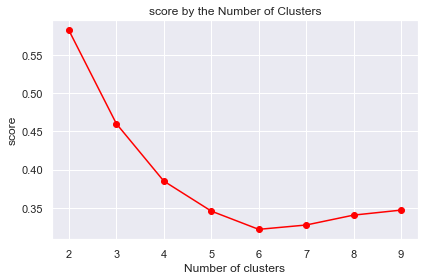

In [141]:
# silhoute method
range_n_clusters = range(2,10)

score = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(X_scaled)
    cluster = kmeans.predict(X_scaled)
    s=metrics.silhouette_score(X_scaled, cluster, metric='euclidean')
    score.append(s)
plt.plot(range_n_clusters, score, marker='o',color='red')
plt.xlabel('Number of clusters')
plt.ylabel('score')
plt.title('score by the Number of Clusters')
plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.58
For n_clusters = 3 The average silhouette_score is : 0.46
For n_clusters = 4 The average silhouette_score is : 0.38
For n_clusters = 5 The average silhouette_score is : 0.34
For n_clusters = 6 The average silhouette_score is : 0.32


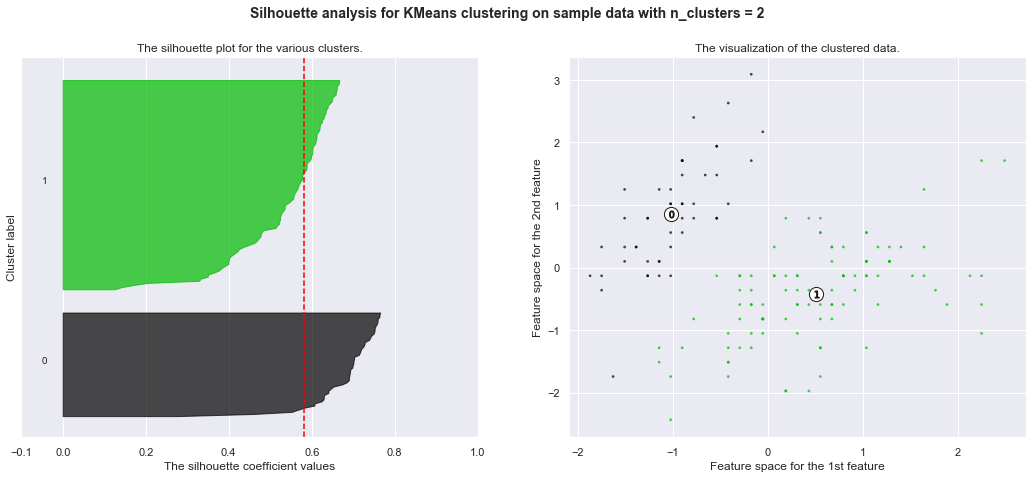

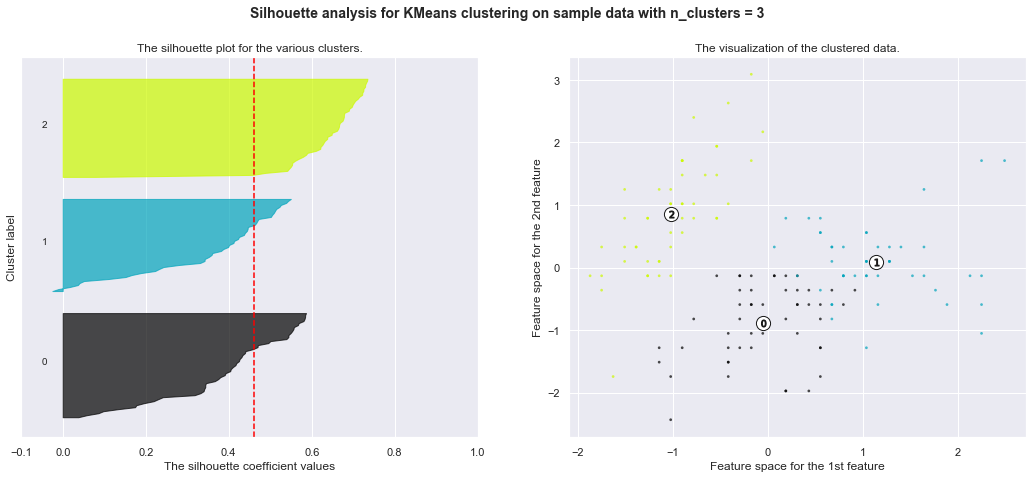

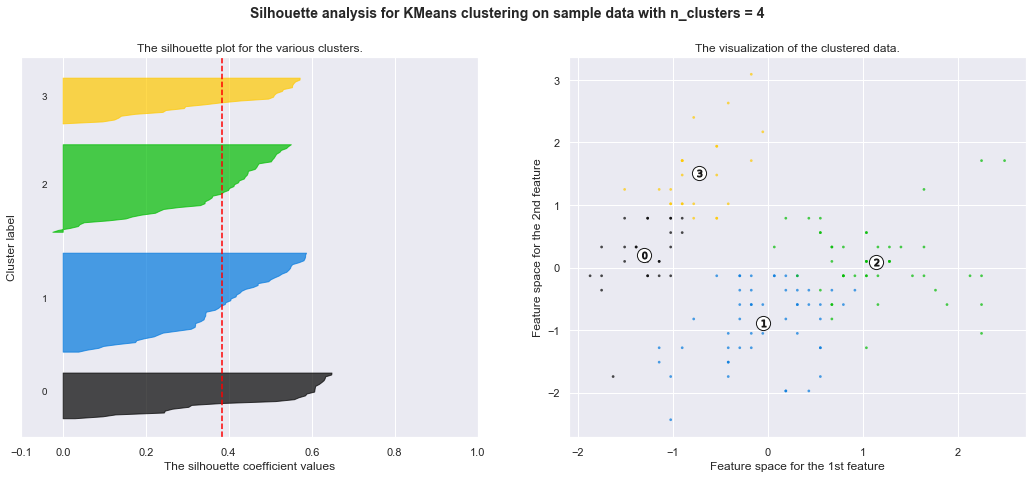

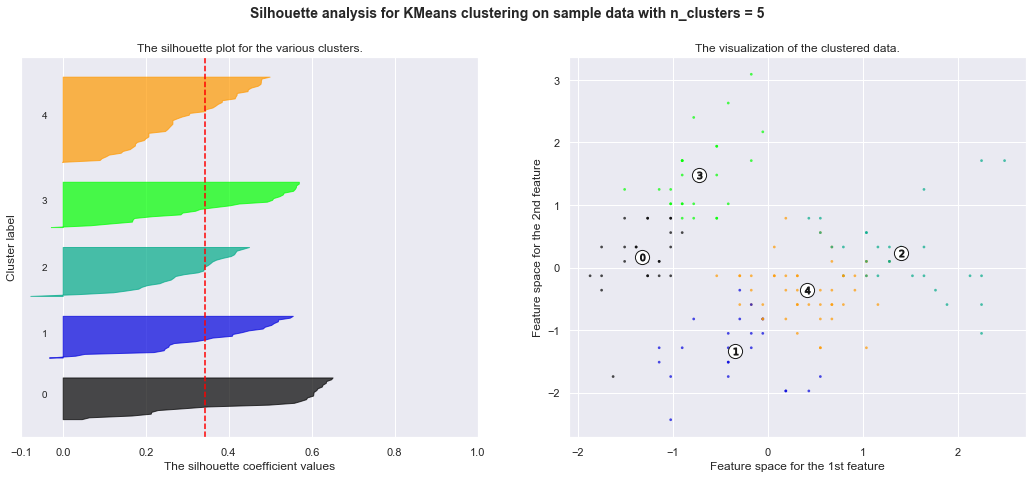

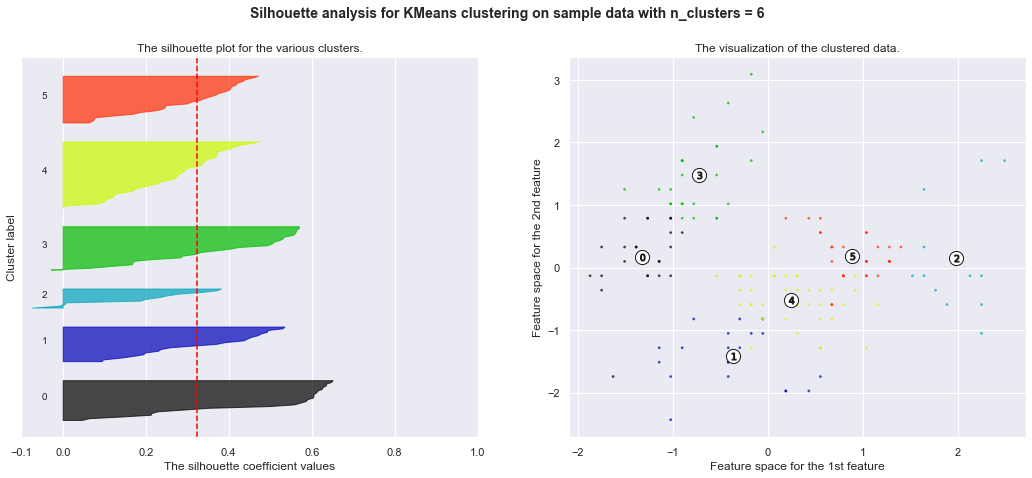

In [142]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg, 2))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
# Does scaling the data improve the performance of your clustering?

In [151]:
# with scale
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(X_scaled)
cluster = kmeans.predict(X_scaled)


print( "rand: ",metrics.adjusted_rand_score(y, cluster))

s=metrics.silhouette_score(X_scaled, cluster, metric='euclidean')
print('silhouette_score:', s)

db=davies_bouldin_score(X_scaled, cluster)  
print('davies_bouldin_score: ', db)

rand:  0.6201351808870379
silhouette_score: 0.45994823920518635
davies_bouldin_score:  0.8335949464754338


In [152]:
#without scale
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(X)
cluster = kmeans.predict(X)


print( "rand: ",metrics.adjusted_rand_score(y, cluster))

s=metrics.silhouette_score(X, cluster, metric='euclidean')
print('silhouette_score:', s)

db=davies_bouldin_score(X, cluster)  
print('davies_bouldin_score: ', db)

rand:  0.7302382722834697
silhouette_score: 0.5528190123564091
davies_bouldin_score:  0.6619715465007542


## Density-Based Spatial Clustering of Applications with Noise (DBSCAN):

Another very useful clustering algorithm is **DBSCAN** (which stands for "density based
spatial clustering of applications with noise"). The main benefits of DBSCAN are that it does not require the user to set the number of clusters a priori, it can capture clusters of complex shapes, and it can identify points that are not part of any
cluster. DBSCAN is somewhat slower than other clustering algorithms, but still scales to relatively large datasets.

DBSCAN works by identifying points that are in "crowded" regions of the feature space, where many data points are close together. These regions are referred to as dense regions in feature space. The idea behind DBSCAN is that clusters form dense
regions of data, separated by regions that are relatively empty.

Points that are within a dense region are called core samples (or core points). There are two parameters in DBSCAN: `min_samples` and `eps`. If there are at least `min_samples` number of data points within a distance of `eps` to a given
data point, that data point is classified as a core sample. Core samples that are closer to each other than the distance eps are put into the same cluster by DBSCAN.

#### How does this work?

The algorithm works by picking an arbitrary point to start with. It then finds all points with distance `eps` or less from that point. If there are *less* than `min_samples` points within distance `eps` of the starting point, this point is labeled as "noise", meaning that it doesn't belong to any cluster. If there are more than `min_samples` points within a distance of `eps`, the point is labeled a "core sample" and assigned a new cluster label. Then, all neighbors (within `eps`) of the point are visited. If they have not been assigned a cluster yet, they are assigned the new cluster label that was just created. If
they are core samples, their neighbors are visited in turn, and so on. The cluster
grows until there are no more core samples within distance `eps` of the cluster. Then another point that hasn't yet been visited is picked, and the same procedure is repeated.

Concisely, in DBSCAN, a special label is assigned to each sample (point) using the following criteria:
 - **Core Sample:** A point is considered as *core sample* if at least a specified number (`min_samples`) of neighboring points fall within the specified radius `eps`.
 - **Boundary Point**: It is a point that has fewer neighbors than `min_samples` within `eps`, but lies within the `eps` radius of a core point. Means that the boundary point itself doesn't meet the `min_samples` criteria.
 - **Noise**: All other points that are neither core nor border points are considered as *noise* points.
 
 ![(image)](../images/dbscan.png)

For this algorithm we need to `fit_predict` at the same time to perform clustering and
return the cluster labels in one step:

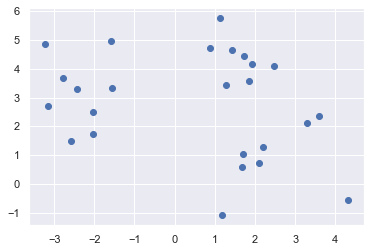

In [153]:
from sklearn.cluster import DBSCAN

X, y = make_blobs(random_state=0, n_samples=25)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [155]:
dbscan = DBSCAN()
print(dbscan)
clusters = dbscan.fit_predict(X)
print("Cluster memberships:\n{}".format(clusters))

# all noise

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)
Cluster memberships:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]


Opps! As you can see, all data points were assigned the label -1, which stands for noise. This is a consequence of the default parameter settings for eps and min_samples, which are not tuned for small toy datasets. Let's try other combination of settings then...

In [156]:
for ms in list([3, 4, 5]):
    for e in list([1, 1.5, 2]):
        dbscan = DBSCAN(min_samples=ms, eps=e)
        clusters = dbscan.fit_predict(X)
        print(" min samples= ", ms, " eps= ", e, "\n \n clusters: ", clusters, '\n\n************************\n')

 min samples=  3  eps=  1 
 
 clusters:  [ 0  1  0  0  1 -1 -1  0  0  2  2  1  1  0  1  1 -1 -1  2  0 -1  1 -1  2
 -1] 

************************

 min samples=  3  eps=  1.5 
 
 clusters:  [ 0  1  0  0  1  2  1  0  0  2  2  1  1  0  1  1  0  2  2  0 -1  1 -1  2
 -1] 

************************

 min samples=  3  eps=  2 
 
 clusters:  [ 0  1  0  0  1  2  1  0  0  2  2  1  1  0  1  1  0  2  2  0 -1  1  1  2
  2] 

************************

 min samples=  4  eps=  1 
 
 clusters:  [ 0  1  0  0  1 -1 -1  0  0  2  2  1 -1  0  1  1 -1 -1  2  0 -1  1 -1  2
 -1] 

************************

 min samples=  4  eps=  1.5 
 
 clusters:  [ 0  1  0  0  1  2  1  0  0  2  2  1  1  0  1  1  0 -1  2  0 -1  1 -1  2
 -1] 

************************

 min samples=  4  eps=  2 
 
 clusters:  [ 0  1  0  0  1  2  1  0  0  2  2  1  1  0  1  1  0  2  2  0 -1  1  1  2
  2] 

************************

 min samples=  5  eps=  1 
 
 clusters:  [ 0  1  0  0  1 -1 -1  0  0 -1 -1  1 -1  0 -1  1 -1 -1 -1  0 -1  1 -1 -1


Let's take a closer look at some of these settings, particularly those that have clear cut clusters (cluster numbers 0, 1, 2), and those with some noise points.

`DBSCAN` comes with some nice properties. **`core_sample_indices_`** gets us the indices of the core samples, whereas noise samples can be found by the label -1, what remains are the boundary samples. Let's create a plot.

In [157]:
ms = 3
ep = 1
dbscan = DBSCAN(min_samples=ms, eps=ep)
clusters = dbscan.fit_predict(X)
print("Clusters:",clusters)
print("===============================")

all_samples = np.arange(0,len(X))
print("All samples:",all_samples)
print("===============================")

core = dbscan.core_sample_indices_     
print("Core:", core)
print("===============================")

noise = np.where(clusters == -1)[0]        
print("Noise:", noise)
print("===============================")

boundary = np.setdiff1d(np.setdiff1d(all_samples, core), noise)
print("Boundary:", boundary)

Clusters: [ 0  1  0  0  1 -1 -1  0  0  2  2  1  1  0  1  1 -1 -1  2  0 -1  1 -1  2
 -1]
All samples: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Core: [ 0  1  2  3  4  7  8  9 10 11 13 14 18 19 23]
Noise: [ 5  6 16 17 20 22 24]
Boundary: [12 15 21]


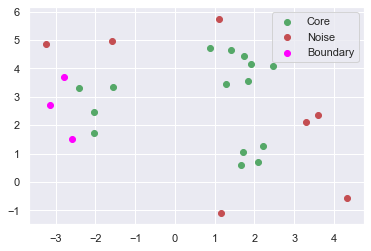

In [158]:
plt.scatter(X[core,0], X[core,1], c='g', label='Core')
plt.scatter(X[noise,0], X[noise,1], c='r', label='Noise')
plt.scatter(X[boundary,0], X[boundary,1], c='magenta', label='Boundary')
plt.legend()
plt.show()

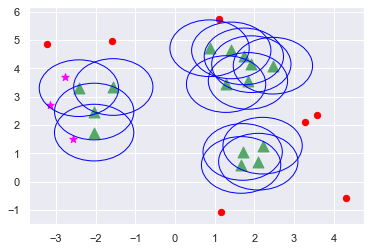

In [159]:
# plot all three types of points
fig, ax = plt.subplots() 
plt.scatter(X[boundary,0], X[boundary,1], 
            c='magenta', cmap='viridis', 
             marker='*', s=60)

plt.scatter(X[core,0], X[core,1], 
            c='g', cmap='viridis', 
             marker='^', s=120)

plt.scatter(X[noise,0], X[noise,1], 
            c='red', cmap='viridis', 
            marker='o', s=40)

# draw circles of radius eps around each core sample
for i in core:
    circle = plt.Circle((X[i, 0], X[i, 1]), ep, color='blue', Fill=False)
    ax.add_artist(circle)

plt.show()

**Tip**: While DBSCAN doesn’t require setting the number of clusters explicitly, setting `eps` implicitly controls how many clusters will be found. Finding a good setting for `eps` is sometimes easier after scaling the data using `StandardScaler` or `MinMaxScaler` ([here](http://scikit-learn.org/stable/modules/preprocessing.html) is more information), as using these scaling techniques.

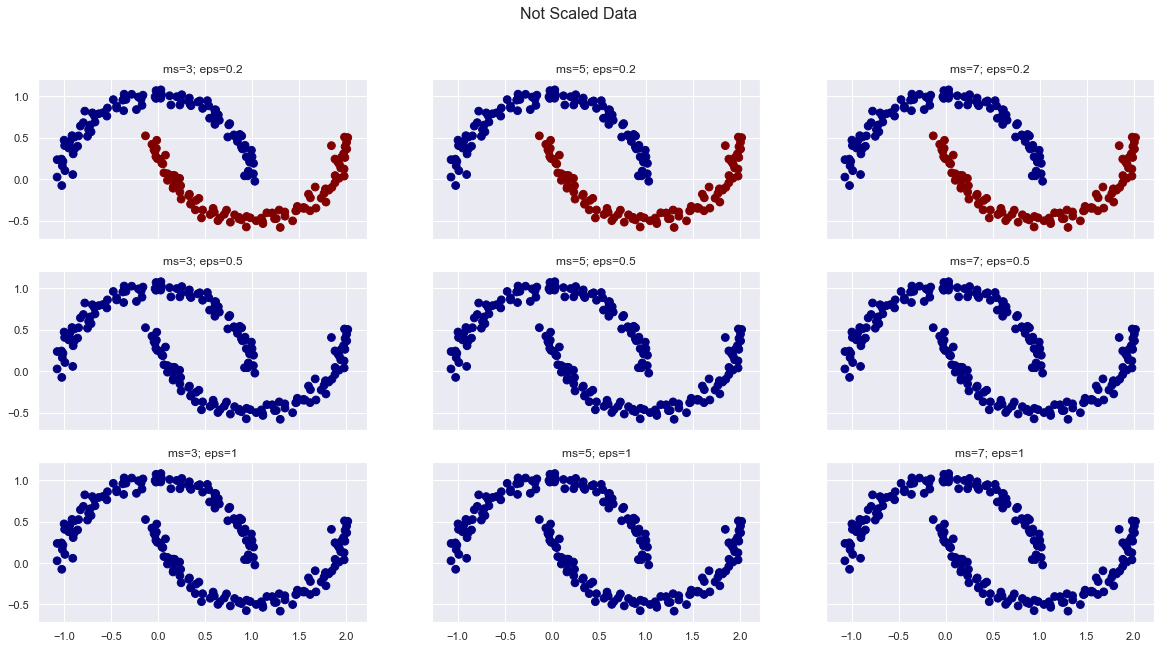

In [160]:
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 10))
fig.suptitle("Not Scaled Data", fontsize=16)

i=0
for e in list([0.2, 0.5, 1]):
    j=0
    for ms in list([3, 5, 7]):
        dbscan = DBSCAN(min_samples=ms, eps=e)
        clusters = dbscan.fit_predict(X)
        # plot the cluster assignments
        ax[i,j].scatter(X[:, 0], X[:, 1], c=clusters, cmap='jet', s=60)
        t='ms='+str(ms)+'; eps='+str(e)
        ax[i,j].set_title(t)
        j=j+1
    i=i+1 


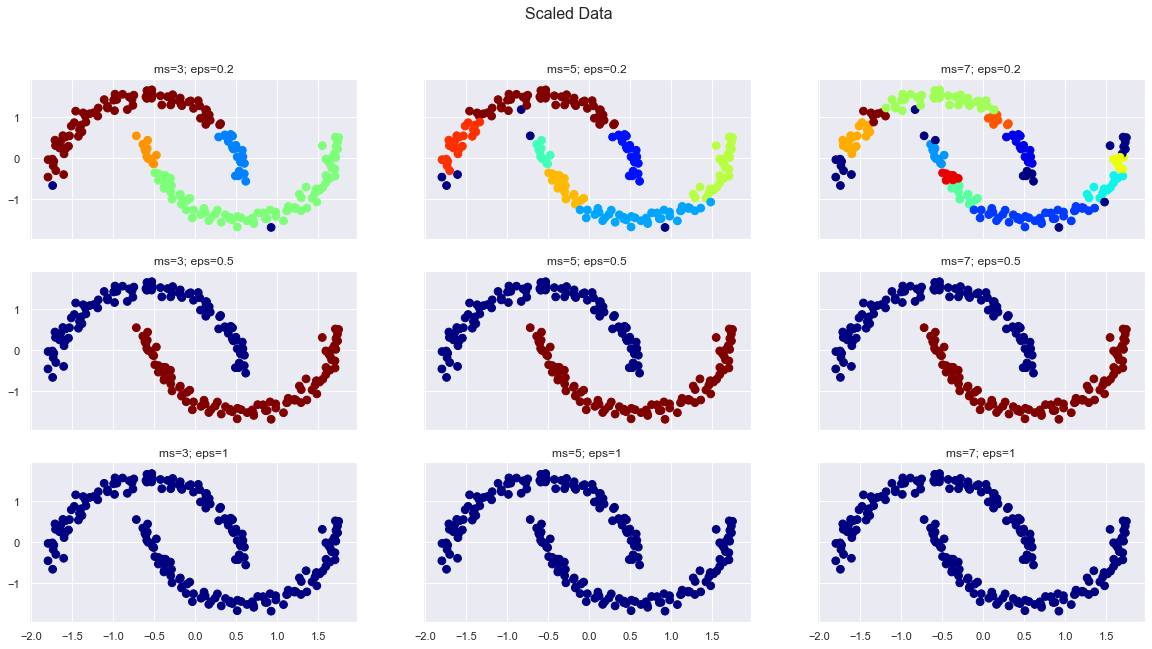

In [161]:
# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 10))
fig.suptitle("Scaled Data", fontsize=16)
i=0
for e in list([0.2, 0.5, 1]):
    j=0
    for ms in list([3, 5, 7]):
        dbscan = DBSCAN(min_samples=ms, eps=e)
        clusters = dbscan.fit_predict(X_scaled)
        # plot the cluster assignments
        ax[i,j].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='jet', s=60)
        t='ms='+str(ms)+'; eps='+str(e)
        ax[i,j].set_title(t)
        j=j+1
    i=i+1 



Perfect!

One of the main advantages of using DBSCAN is that it does not assume that the clusters have a spherical shape as in k-means. Furthermore, DBSCAN is different from k-means and hierarchical clustering in that it doesn't necessarily assign each point to a cluster but is capable of removing noise points if they fall too far from significant clusters.

**Exercise: Iris DBSCAN**
Repeate the previous exercise for DBSCAN.

In [162]:
# get Iris

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [183]:
# Scaling data

# Choose 1
S_scaler=StandardScaler()
X_S=S_scaler.fit_transform(X)

# M_scaler=MinMaxScaler(feature_range=(0, 1))
# X_M=M_scaler.fit_transform(X)

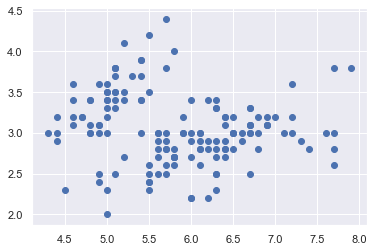

In [180]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [200]:
for ms in list([3, 5, 8]):
    for e in list([0.3, 0.5,1, 1.5]):
        dbscan = DBSCAN(min_samples=ms, eps=e)
        cluster1 = dbscan.fit_predict(X_S)
        print(" min samples= ", ms, " eps= ", e, "\n \n clusters: ", cluster1, '\n\n************************\n')

 min samples=  3  eps=  0.3 
 
 clusters:  [ 0  1  1  1  0 -1  0  0  3  1 -1  0  1  3 -1 -1 -1  0 -1  2  0  2 -1  0
  0  1  0  0  0  1  1  0 -1 -1  1  0 -1  0  3  0  0 -1  1 -1  2  1  2  1
 -1  0 -1 -1  5 -1 -1  4 -1 -1  5 -1 -1 -1 -1  5 -1  5 -1  7 -1  6 -1 -1
 -1 -1  5  5 -1 -1  5 -1  6  6  7 -1 -1 -1  5 -1  4  6 -1  5  7 -1  4  4
  4  5 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  8 -1 -1  8  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  9] 

************************

 min samples=  3  eps=  0.5 
 
 clusters:  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  2  1 -1 -1  1 -1  1  1  1  1  1  3  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  2  1  1
  1  1  2  1  6  1  1  1  1  4 -1  5 -1 -1  1  1  1  1 -1  1  1 -1 -1  3
  1  1  4  1  1 -1  1  1  1  5  5 -1  1  1  1  4  6  1  1  1  1

Clusters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
All samples: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Core: [  0   1   2   3   4   5   6   7   8   9  10  11  12  1

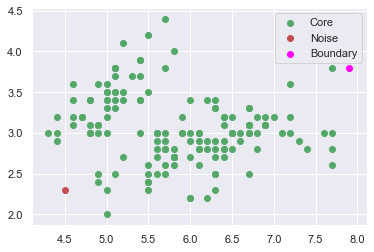

In [201]:
ms = 3
ep = 1
dbscan = DBSCAN(min_samples=ms, eps=ep)
cluster1 = dbscan.fit_predict(X_S)
print("Clusters:",clusters)
print("===============================")

all_samples = np.arange(0,len(X_S))
print("All samples:",all_samples)
print("===============================")

core = dbscan.core_sample_indices_     
print("Core:", core)
print("===============================")

noise = np.where(cluster1 == -1)[0]        
print("Noise:", noise)
print("===============================")

boundary = np.setdiff1d(np.setdiff1d(all_samples, core), noise)
print("Boundary:", boundary)

plt.scatter(X[core,0], X[core,1], c='g', label='Core')
plt.scatter(X[noise,0], X[noise,1], c='r', label='Noise')
plt.scatter(X[boundary,0], X[boundary,1], c='magenta', label='Boundary')
plt.legend()
plt.show()

In [202]:
from scipy.stats import mode #most common value

labels = np.zeros_like(cluster)
for i in range(4):
    mask = (cluster1 == i)
    most_occurring = mode(y[mask])[0]
    labels[mask] = most_occurring
    print("cluster:",i,"label:",most_occurring)

cluster: 0 label: [0]
cluster: 1 label: [1]
cluster: 2 label: []
cluster: 3 label: []


In [203]:
ms = 3
ep = 1
dbscan = DBSCAN(min_samples=ms, eps=ep)
cluster1 = dbscan.fit_predict(X_S)

print( "rand_score: ",metrics.adjusted_rand_score(y, cluster1))

s=metrics.silhouette_score(X_S, cluster1, metric='euclidean')
print('silhouette_score:', s)

db=davies_bouldin_score(X_S, cluster1)  
print('davies_bouldin_score: ', db)

rand_score:  0.5583714437541352
silhouette_score: 0.5046456108325449
davies_bouldin_score:  0.4929252276829148


In [204]:
ms = 3
ep = 1
dbscan = DBSCAN(min_samples=ms, eps=ep)
cluster = dbscan.fit_predict(X)

print( "rand_score: ",metrics.adjusted_rand_score(y, cluster))

s=metrics.silhouette_score(X, cluster, metric='euclidean')
print('silhouette_score:', s)

db=davies_bouldin_score(X, cluster)  
print('davies_bouldin_score: ', db)

rand_score:  0.5681159420289855
silhouette_score: 0.6867350732769776
davies_bouldin_score:  0.3827528421006907


In [ ]:
y

In [ ]:
clusters

In [ ]:
clusters_S

In [ ]:
clusters_M

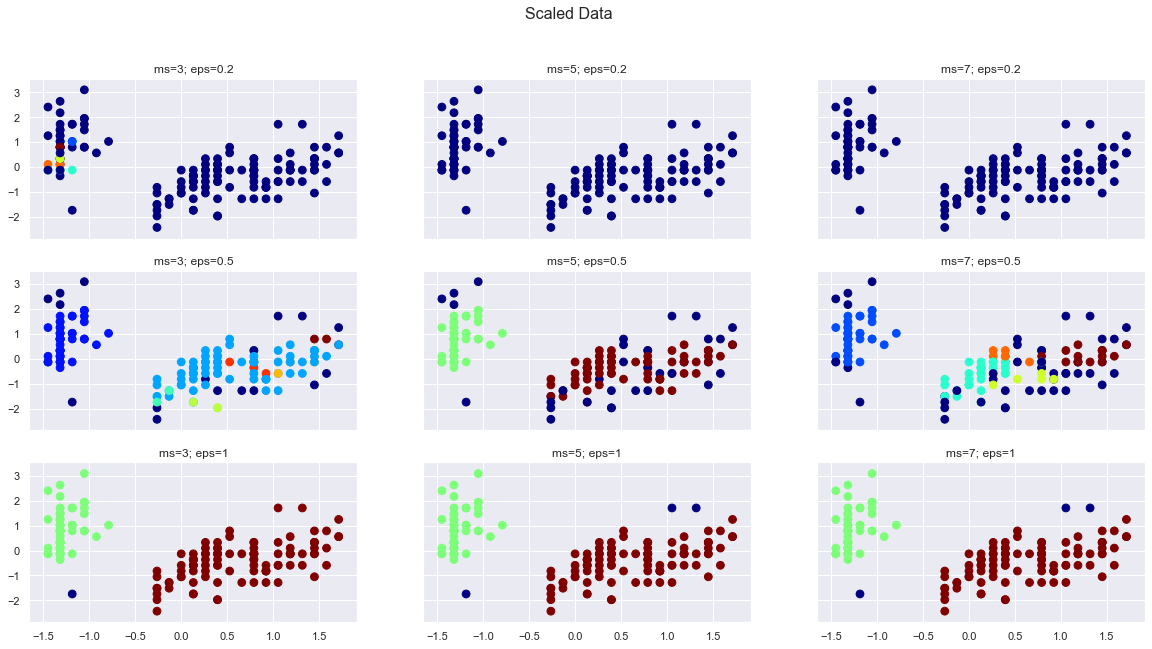

In [221]:
# MC
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 10))
fig.suptitle("Scaled Data", fontsize=16)
i=0
for e in list([0.2,0.5, 1]):
    j=0
    for ms in list([3, 5, 7]):
        dbscan = DBSCAN(min_samples=ms, eps=e)
        clusters = dbscan.fit_predict(X_S)
        # plot the cluster assignments
        ax[i,j].scatter(X_S[:, 3], X_S[:, 1], c=clusters, cmap='jet', s=60)
        t='ms='+str(ms)+'; eps='+str(e)
        ax[i,j].set_title(t)
        j=j+1
    i=i+1 


## Agglomerative Clustering

**Agglomerative clustering** refers to a collection of clustering algorithms that all build upon the same principles: the algorithm starts by declaring each point its own cluster, and then merges the two most similar clusters until some stopping criterion is satisfied. The stopping criterion implemented in `scikit-learn` is the number of clusters, so similar clusters are merged until only the specified number of clusters are left. There are several linkage criteria that specify how exactly the "most similar cluster" is measured. This measure is always defined between two existing clusters.
The following three choices are implemented in scikit-learn:
* *ward*: The default choice, ward picks the two clusters to merge such that the variance
within all clusters increases the least. This often leads to clusters that are relatively
equally sized.
* *average*: Average linkage merges the two clusters that have the smallest average distance
between all their points.
* *complete*: Complete linkage (also known as maximum linkage) merges the two clusters that
have the smallest maximum distance between their points.

*ward* works on most datasets, and we will use it in our examples. If the clusters have very dissimilar numbers of members (if one is much bigger than all the others, for example), *average* or *complete* might work better. The following are some commonly used cluster distances, and their respective expressions:

![](../images/cluster-distances.png)


The following figure illustrates the progression of agglomerative clustering on a two-dimensional dataset, looking for three clusters:

![](../images/agglomerative-steps.png)

Initially, each point is its own cluster. Then, in each step, the two clusters that are closest are merged. In the first four steps, two single-point clusters are picked and these are joined into two-point clusters. In step 5, one of the two-point clusters is extended to a third point, and so on. In step 9, there are only three clusters remaining. As we specified that we are looking for three clusters, the algorithm then stops. Let's have a look at how agglomerative clustering performs on the simple three cluster data we used here. Because of the way the algorithm works, agglomerative
clustering cannot make predictions for new data points. Therefore, `AgglomerativeClustering` has no `predict` method. To build the model and get the cluster memberships on the training set, use the `fit_predict` method instead.

Text(0, 0.5, 'Feature 1')

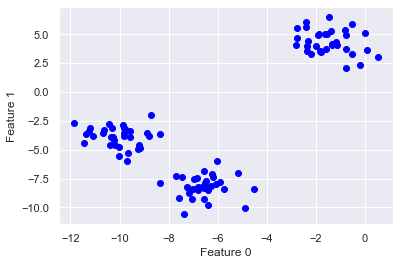

In [210]:
X, y = make_blobs(random_state=1)

plt.scatter(X[:, 0], X[:, 1],c='blue')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

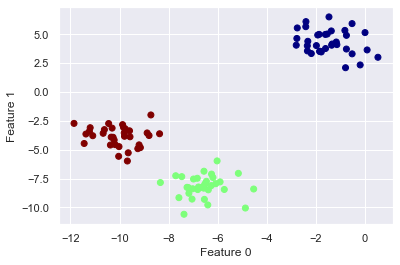

In [211]:
from sklearn.cluster import AgglomerativeClustering
# linkage: {“ward”, “complete”, “average”, “single”}

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
assignment = agg.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=assignment, cmap='jet')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

As expected, we get the same results here with such a simple dataset. While the `scikit-learn`
implementation of agglomerative clustering requires you to specify the number of
clusters you want the algorithm to find, agglomerative clustering methods provide
some help with choosing the right number, which we will come to next.

### Dendrogram

Agglomerative clustering produces what is known as a *hierarchical clustering*. The clustering proceeds iteratively, and every point makes a journey from being a single point cluster to belonging to some final cluster. Each intermediate step provides a
clustering of the data (with a different number of clusters). The figure below shows an example of some data points which have been clustered in a hierarchical way, providing some insight into how each cluster breaks up into smaller clusters:
<img src="../images/hierarchical-clusters.png" width="400" />

Visualizing this way is somewhat limited to only 2-D data. There is another way to visualize hierarchical clustering, called a *dendrogram*, that can handle multi-dimensional datasets. A **dendrogram** is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering.

`scikit-learn` does not have the functionality to draw the dendrogram, but we can go to the SciPy library to generate it. Clustering algorithms in SciPy are slightly different in terms of usage. SciPy provides a function that takes a data array X and computes a *linkage array*, which encodes hierarchical cluster similarities. We can then feed this linkage array into the SciPy `dendrogram` function to plot the dendrogram.

In [212]:
from scipy.cluster.hierarchy import ward    #single, complete, average, weighted, centroid, median

X, y = make_blobs(random_state=0, n_samples=12)

# ward function returns an array that specifies the distances between clusters
linkage_array = ward(X)
print(linkage_array)

[[ 1.          4.          0.3320945   2.        ]
 [ 6.          9.          0.64580193  2.        ]
 [ 2.          8.          0.92683223  2.        ]
 [ 0.         11.          1.1803787   2.        ]
 [ 5.         15.          1.30311575  3.        ]
 [ 7.         13.          1.4440339   3.        ]
 [ 3.         14.          1.60041812  3.        ]
 [12.         18.          2.07815795  5.        ]
 [10.         17.          2.15981886  4.        ]
 [16.         20.          6.55024854  7.        ]
 [19.         21.          7.92446877 12.        ]]


We can observe that until iteration 4 the algorithm only directly merged original samples. We can also observe the monotonic increase of the distance.


In iteration 4 the algorithm decided to merge cluster indices 5 with 15.
**Q:** What is index 15?

In [214]:
print(linkage_array[4,:])

[ 5.         15.          1.30311575  3.        ]


Such distance jumps / gaps in the linkage_array are pretty interesting for us. They indicate that maybe the things that were merged here really don't belong to the same cluster.

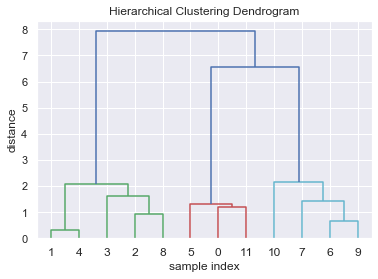

In [215]:
# plot the dendrogram 
from scipy.cluster.hierarchy import dendrogram


plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(linkage_array)
plt.show()

The dendrogram shows data points as points on the bottom (numbered from 0 to 11). Then, a tree is plotted with these points (representing single-point clusters) as the leaves, and a new parent node is added for each two clusters that are joined. At the top level, there are two branches, one consisting of points 5, 0, 11, 10, 7, 6, and 9, and the other consisting of points 1, 4, 3, 2, and 8. These correspond to the two largest clusters.

**Example:** 
Use hierarchical clustering for the following dataset.

(150, 2)


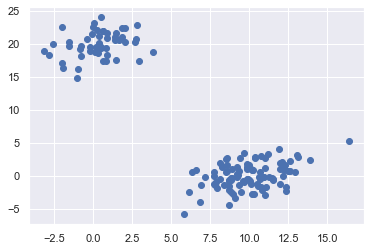

In [216]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X1 = np.concatenate((a, b),)

print(X1.shape)  

plt.scatter(X1[:,0], X1[:,1])
plt.show()

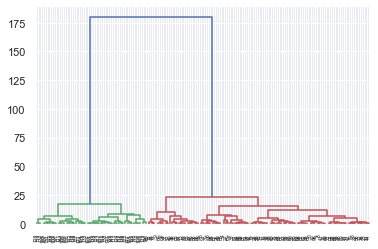

In [217]:
Z1 = ward(X1)     
dendrogram(Z1)
plt.show()

#### Dendrogram Truncation



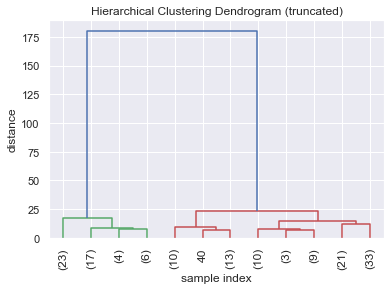

In [218]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(
    Z1,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,                   # p is the number of last clusters merged 
    leaf_rotation=90,
    leaf_font_size=12)

plt.show()

The above shows a truncated dendrogram, which only shows the last p=12 out of our 149 merges.

#### Interpreting the dendrogram further

The y-axis in the dendrogram doesn't just specify when in the agglomerative algorithm two clusters get merged. The length of each branch also shows how far apart the merged clusters are. 

**Exercise:**
For the following dataset use hierarchical clustering and compare the dendrograms for different linkage types.

D:\Users\Faiz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


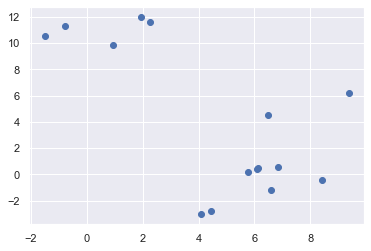

In [224]:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([5, 0], [[3, 2], [1, 4]], size=[10,])
b = np.random.multivariate_normal([0, 10], [[3, 1], [1, 4]], size=[5,])
X2 = np.concatenate((a, b),)

plt.scatter(X2[:,0], X2[:,1])
plt.show()

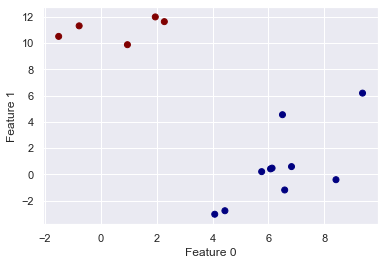

In [245]:
from sklearn.cluster import AgglomerativeClustering
# linkage =['ward', 'complete', 'average', 'single']
model = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster = model.fit_predict(X2)

plt.scatter(X2[:, 0], X2[:, 1], c=cluster, cmap='jet')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

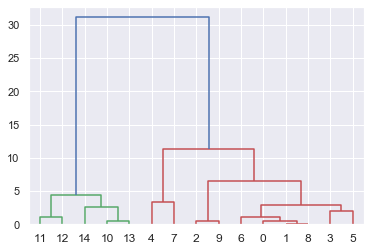

In [241]:
# dendogram
dendrogram(ward(X2))
# dendrogram(ward(X2), truncate_mode='lastp',p=12) if groping them
plt.show()

### Cophenetic Correlation Coefficient

One thing we can do to check if our choice of distance metric is good is to check the Cophenetic Correlation Coefficient of your clustering with help of the `cophenet()` function. This compares the actual pairwise distances of all your samples and those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances.

In [267]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

X, y = make_blobs(random_state=0, n_samples=12)
linkage_array = ward(X)

# pdist function returns a distance matrix representing distance of all sample pairs

c, coph_dists = cophenet(linkage_array, pdist(X))
print(c)

0.8121412861495917


In [252]:
linkage_array

array([[ 1.        ,  4.        ,  0.3320945 ,  2.        ],
       [ 6.        ,  9.        ,  0.64580193,  2.        ],
       [ 2.        ,  8.        ,  0.92683223,  2.        ],
       [ 0.        , 11.        ,  1.1803787 ,  2.        ],
       [ 5.        , 15.        ,  1.30311575,  3.        ],
       [ 7.        , 13.        ,  1.4440339 ,  3.        ],
       [ 3.        , 14.        ,  1.60041812,  3.        ],
       [12.        , 18.        ,  2.07815795,  5.        ],
       [10.        , 17.        ,  2.15981886,  4.        ],
       [16.        , 20.        ,  6.55024854,  7.        ],
       [19.        , 21.        ,  7.92446877, 12.        ]])

In [255]:
from scipy.cluster.hierarchy import single,complete,average

Z = single(X)
c, coph_dists = cophenet(Z, pdist(X))
print(c)

Z = complete(X)
c, coph_dists = cophenet(Z, pdist(X))
print(c)

Z = average(X)
c, coph_dists = cophenet(Z, pdist(X))
print(c)

0.7898426162175275
0.8426771662540814
0.8452151291186623


So, **average** linkage may be a slightly better option compared the the ward linkage.

**Exercise:**
Cluster the following dataset using hierarchical clustering with linkage: {ward, complete, average, single}

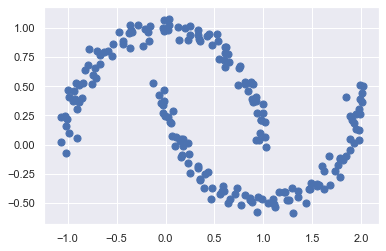

In [269]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

plt.scatter(X[:,0],X[:,1],s=50,cmap='viridis')

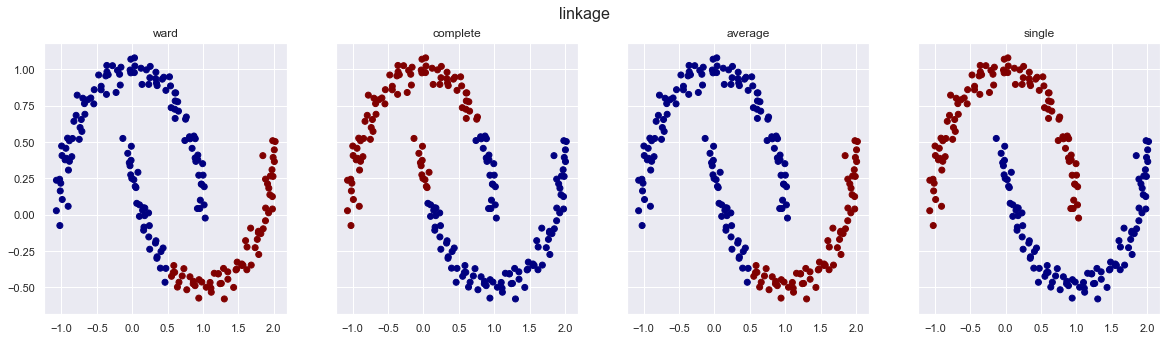

In [270]:
from sklearn.cluster import AgglomerativeClustering
# linkage =['ward', 'complete', 'average', 'single']

fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(20,5))
fig.suptitle("linkage", fontsize=16)

linkage =['ward', 'complete', 'average', 'single']

for i in range(4):
    model = AgglomerativeClustering(n_clusters=2, linkage=linkage[i])
    cluster = model.fit_predict(X)
    ax[i].scatter(X[:, 0], X[:, 1], c=cluster, cmap='jet')
    ax[i].set_title(linkage[i])
    
plt.show()

**Exercise:** 
Cluster iris dataset using hierarchical clustering with linkage: {ward, complete, average, single}

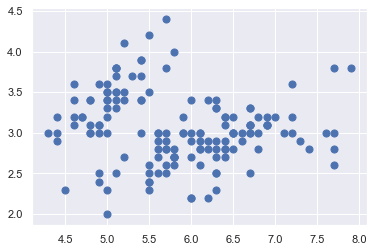

In [279]:
iris=datasets.load_iris()
X=iris.data
y=iris.target
plt.scatter(X[:,0],X[:,1],s=50,cmap='viridis')

In [277]:
# Scaling data

# Choose 1
S_scaler=StandardScaler()
X_S=S_scaler.fit_transform(X)

# M_scaler=MinMaxScaler(feature_range=(0, 1))
# X_M=M_scaler.fit_transform(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

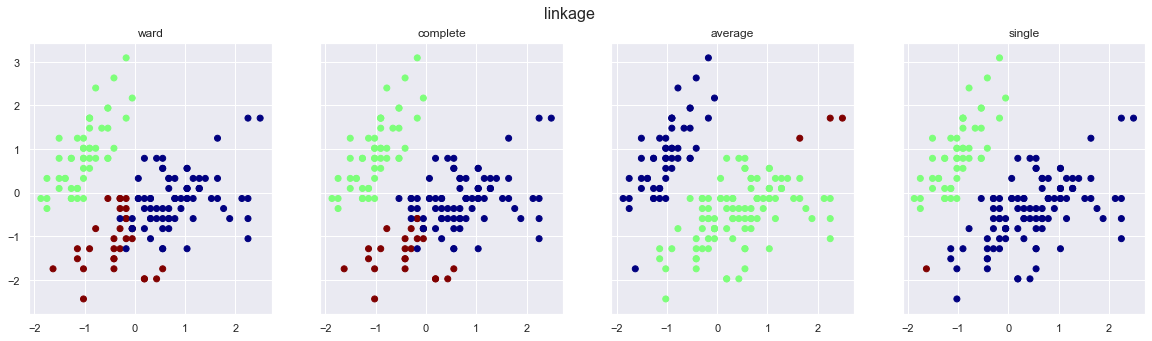

In [291]:
fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(20,5))
fig.suptitle("linkage", fontsize=16)

linkage =['ward', 'complete', 'average', 'single']

for i in range(4):
    model = AgglomerativeClustering(n_clusters=3, linkage=linkage[i])
    cluster = model.fit_predict(X_S)
    ax[i].scatter(X_S[:, 0], X_S[:, 1], c=cluster, cmap='jet')
    ax[i].set_title(linkage[i])
    # print("Accuracy",linkage[i], accuracy_score(y,cluster)) need to map the label first
plt.show()

cluster: 0 label: [1]
cluster: 1 label: [0]
cluster: 2 label: [2]
Accuracy 0.9066666666666666


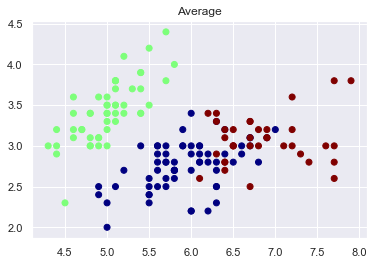

In [282]:
# MC
iris = datasets.load_iris()
X = iris.data
y = iris.target

from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3, linkage='average')
assignment = agg.fit_predict(X)

from scipy.stats import mode #most common value

labels = np.zeros_like(assignment)

for i in range(3):
    mask = (assignment == i)
    most_occurring = mode(y[mask])[0]
    labels[mask] = most_occurring
    print("cluster:",i,"label:",most_occurring)

plt.scatter(X[:, 0], X[:, 1], c=assignment, cmap='jet')
plt.title("Average")
print("Accuracy", accuracy_score(y,labels))

# Reference
1. Python Data Science Handbook

https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

2. Handling categorical variables for clustering: https://pypi.org/project/kmodes/

3. Clustering by Andrew Ng: https://www.youtube.com/watch?v=Ev8YbxPu_bQ